In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
from progress_bar1 import ProgressBar
import createdb as cdb
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GRID K520 (CNMeM is disabled)


In [2]:
opts = {'img_dir': '../data/intestinalparasites/',
        'models_dir': '../models/',
        'annotation_dir': '../data/intestinalparasites/',
        'train-dir': 'train_dir/',
        'test-dir': 'test_dir/',
        'val-dir': 'val_dir/',
        'patches_dir': 'patches_dir/',
        'augment-training-data': False,
        'model': '2C-1FC-O',
        'threshold': 0.9, 
        'overlapThreshold': 0.3, 
        'lim': 0, 
        'gauss': 1,
        'prob': det.MAX, 
        'pos': det.MAX, 
        'probs_area': 90,
        'input_scale': None,
        'raw_scale': 255,
        'image_dims': (600,600),
        'image_downsample' : 10,
        'channel_swap': None,
        'probs_area': 40,
        'detection-step': 15,
        'patch-creation-step': 40,
        'object-class': 'hookworm',
        'negative-training-discard-rate': .95
       }
opts['patch_stride_training'] = int(opts['image_dims'][0]*.5)

In [3]:
reload(cdb)
trainfiles, valfiles, testfiles = cdb.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.49,
                                                  val_set_proportion=.01)

train_y, train_X = cdb.create_patches_at_center(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object-class'], negative_discard_rate=opts['negative-training-discard-rate'])
test_y, test_X = cdb.create_patches_at_center(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object-class'], negative_discard_rate=opts['negative-training-discard-rate'])
val_y, val_X = cdb.create_patches_at_center(valfiles, opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object-class'], negative_discard_rate=opts['negative-training-discard-rate'])

# For training/validation, cut down on disproportionately large numbers of negative patches
train_X, train_y = cdb.balance(train_X, train_y, mult_neg=100)
val_X, val_y = cdb.balance(val_X, val_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = cdb.augment_positives(train_X, train_y)
val_X, val_y = cdb.augment_positives(val_X, val_y)
#test_X, test_y = cdb.augment_positives(test_X, test_y)


[****************100%******************]  13 of 13 complete


In [4]:
'%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))

'552 positive training examples, 1631 negative training examples'

### View a random selection of positive and negative patches to see if they look right

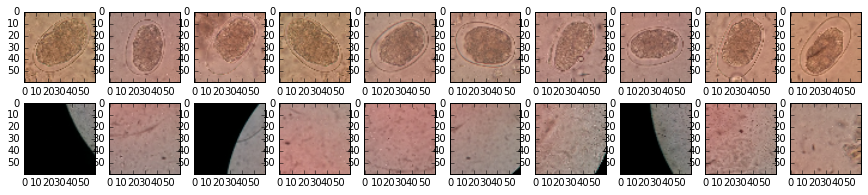

In [5]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos[:,:,[2,1,0]])
    
neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])
    
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

### CNN training

In [6]:
'''        
('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['image_dims'][0]/opts['image_downsample'], 
                 opts['image_dims'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(5, 5), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=50,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1
'''


def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['image_dims'][0]/opts['image_downsample'], 
                 opts['image_dims'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(5, 5), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=50,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(50).fit(train_X, train_y)

# Neural Network with 438432 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    3x60x60
  1  conv1    7x56x56
  2  pool1    7x28x28
  3  conv2    12x27x27
  4  hidden3  50
  5  output   2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.52643       0.50802      3.00467      0.76013  0.34s
      2       0.44673       0.40428      1.10500      0.85069  0.34s
      3       0.34199       0.29998      1.14004      0.91876  0.34s
      4       0.25815       0.29246      0.88268      0.92216  0.34s
      5       0.23542       0.43818      0.53727      0.68157  0.34s
      6       0.18339       0.14019      1.30817      0.96730  0.34s
      7       0.10755       0.11808      0.91084      0.96730  0.34s
      8       0.08948       0.10758      0.83178      0.96730  0.34s
      9       0.07892       0.10765      0.73318      0.96730  0.34s
     

### Make predictions and evaluate on test data

In [7]:
y_pred = cnn.predict_proba(test_X)

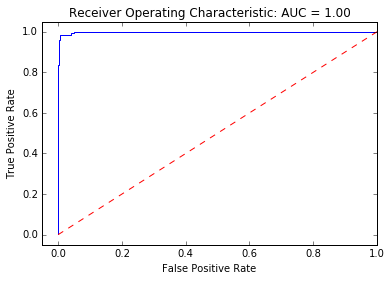

In [8]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

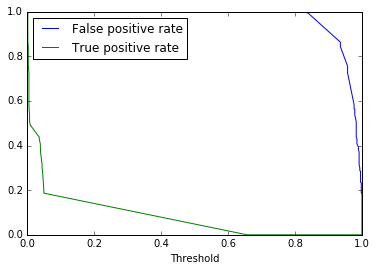

In [36]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='False positive rate')
plt.plot(false_positive_rate, thresholds, label='True positive rate')
plt.xlabel('Threshold')
plt.legend(loc='upper left')

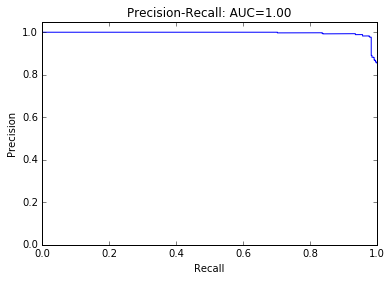

In [9]:
precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

### Examine mistakes to understand network performance - false positives
Find the negative-labelled patches with highest prediction score

[ 0.99949729  0.99438643  0.99434114  0.86256492  0.84338313  0.72920692
  0.72561276  0.72519779  0.56439513  0.5522148 ]


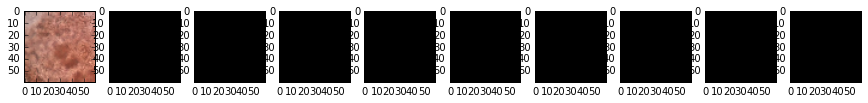

In [38]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]
neg_scores

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

print neg_scores[:N_samples_to_display]

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

See highest-scored test patches

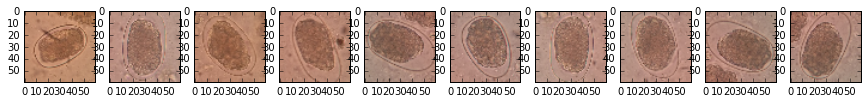

In [10]:
prob_range = [.9,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

Lowest scored test patches

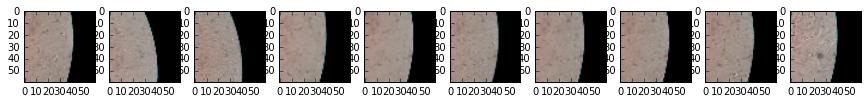

In [11]:
pos_indices = y_pred[:,1].argsort()
#pos_indices = pos_indices[::-1]

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

## Object detection in an entire field of view

In [31]:
imfile = opts['img_dir'] + testfiles[8]
%timeit found = det.detect(imfile, cnn, opts)

1 loops, best of 3: 3.35 s per loop


In [29]:
testfiles[8]

'intestinalparasites-0291.jpg'

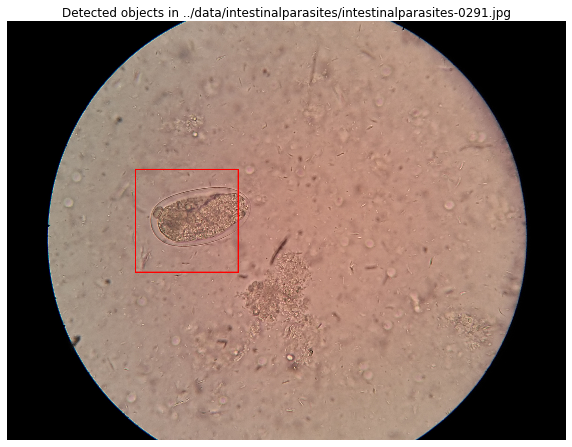

In [30]:
import cv2
im = cv2.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0], f[1]), (f[2],f[3]), (0,0,255), 8)
    
plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im[:,:,[2,1,0]])